<a href="https://colab.research.google.com/github/AmiranGozalishvili/Data_Science_course/blob/main/Earthquake_dataset_Unsupervized_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install plotly --upgrade
# !pip install bds_courseware
# !pip install geopandas

from bds_courseware import read_drive_dataset
from bds_courseware import print_dataset_description, print_module_datasets
from bds_courseware import HOMEWORK_DATASETS
print("Dataset names:", HOMEWORK_DATASETS.keys())
name = "quake"
data = read_drive_dataset(*HOMEWORK_DATASETS[name])
print(data.shape)

Dataset names: dict_keys(['suicide_rates', 'car_perfs', 'brain', 'bank', 'air_quality', 'hypothyroid', 'movies', 'bike_sharing_day', 'bike_sharing_hour', 'quake'])
(2178, 4)


In [ ]:
import numpy as np
import pandas as pd

import itertools

from tqdm.notebook import tqdm as tqdm

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly
print(f"plotly.__version__: {plotly.__version__}")

from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, silhouette_samples


# from shapely.geometry import Point
# import geopandas as gpd
# from geopandas import GeoDataFrame

plotly.__version__: 5.13.1


## EDA

In [ ]:
data.columns

Index(['Focal depth', 'Latitude', 'Longitude', 'Richter'], dtype='object')

In [ ]:
df = data
df_location = data[['Latitude', 'Longitude']]
df_magnitude =data[['Focal depth', 'Richter']]
df.head()

,Focal depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.7
1,36,45.53,150.93,5.8
2,57,41.85,142.78,5.8
3,67,29.19,141.15,6.2
4,30,-21.66,169.81,6.0


In [ ]:
df.describe()

,Focal depth,Latitude,Longitude,Richter
count,2178.000000,2178.000000,2178.000000,2178.000000
mean,74.359963,7.961997,54.914835,5.977181
std,116.467797,30.545583,118.875581,0.189426
min,0.000000,-66.490000,-179.960000,5.800000
25%,21.000000,-12.432500,-67.782500,5.800000
50%,39.000000,0.210000,122.100000,5.900000
75%,68.000000,36.480000,146.860000,6.100000
max,656.000000,78.150000,180.000000,6.900000


I can't understand how can i generate new feature with this dataframe

Question: what will be best new feature and how it is possible to generate?

In [ ]:
df.isna().sum()

Focal depth    0
Latitude       0
Longitude      0
Richter        0
dtype: int64

plot location of earthquakes with respect to depth

In [ ]:
fig = px.scatter_geo(df, lat='Latitude',
                     lon='Longitude',
                     color='Focal depth',
                     width = 1366,
                     height = 768,
                     title='Earthquake locations with respect of epicenter depth'
                     )
fig.show()

plot location of earthquakes with respect to magnitude of Richter

In [ ]:
fig = px.scatter_geo(df, lat='Latitude',
                     lon='Longitude',
                     color='Richter',
                     width = 1366,
                     height = 768,
                     title='Earthquake locations with respect of magnitude strength'
                     )
fig.show()

# Models

I have question about k-means and Agglomerative Clustering methods:

I did't scaled data to use later in this methods. i want to know if it is mistake?

#K-means

K-means is method of clustering based on inertia criteria.
<p> Lets define inertia as $I = \sum_{i=1}^k \sum_{j=1}^{N_i} ||(x_{c_i} - x_{j}^{(i)})||_2$, where k is count of clusters(hyperparameter), $x_{c_i}$ - cluster centroid, $N_i$
 - size of cluster, $x_{j}^{(i)}$ - element of cluster. Vector norm is $L_2$, but we can change it by any metric we want. <p>
This formula defines cluster variance and K-means tries to minimize it with given number of clusters. The minimun value of this loss is 0 when all samples are located at the same point. <p>
Algorythm of training K-means model is paritcular case of E-M algorithm. <p>

<img src="https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif" width="300" height="300">


Drawbacks:

*   Need to select k
*   Decision boundary of cluster is convex so clusters with complex shape cannot be detected
* Depends on initial state as algorythm guarantees only convergence to the local minimum

In [ ]:
def k_means(data, K_nums):
    num_of_k = K_nums
    kmeans = KMeans(n_clusters=num_of_k, random_state=0)
    y_kmeans = kmeans.fit_predict(df)
    nums = []
    labels = []
    for i in range(num_of_k):
        nums.append(i)
        labels.append('label'+str(i))

    kmeans_labels_mapping = dict(zip(nums,
                                     labels))
    kmeans_label = pd.Series(y_kmeans).map(kmeans_labels_mapping)

    fig = px.scatter_geo(df, lon="Longitude", lat='Latitude', color=kmeans_label,
                         width = 1366, height = 768)
    fig.update_layout(title='Earthquakes with Kmeans clusterization')
    fig.show()
    return kmeans_label, y_kmeans, kmeans_labels_mapping

k-means clastering result. num of k = 15

In [ ]:
kmeans_label = k_means(df, 15)

optimize number of K with silhouette and inertia methods

In [ ]:
def optimal_k_num(data):
    Sum_of_squared_distances = []
    K = range(1,10)
    for num_clusters in K:
     kmeans = KMeans(n_clusters=num_clusters)
     kmeans.fit(data)
     Sum_of_squared_distances.append(kmeans.inertia_)

    range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
    silhouette_avg = []
    for num_clusters in range_n_clusters:

      # initialise kmeans
      kmeans = KMeans(n_clusters=num_clusters)
      kmeans.fit(data)
      cluster_labels = kmeans.labels_

      # silhouette score
      silhouette_avg.append(silhouette_score(data, cluster_labels))

    plt.plot(range_n_clusters, silhouette_avg, "bx-")
    plt.xlabel("‘Values of K’")
    plt.ylabel("‘Silhouette score’")
    plt.title("‘Silhouette analysis For Optimal k’")
    plt.show()

    plt.plot(K,Sum_of_squared_distances,"bx-")
    plt.xlabel("Values of K")
    plt.ylabel("Sum of squared distances/Inertia")
    plt.title("Inertia Method For Optimal k")
    plt.show()

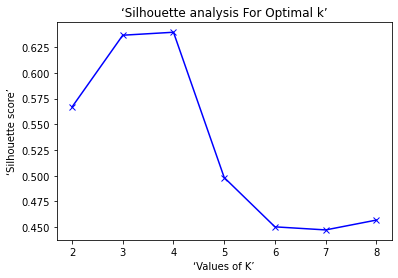

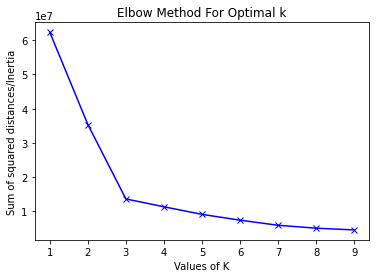

In [ ]:
optimal_k_num(df)

result of optimization shows us that we can get better results when k=3

In [ ]:
kmeans_label, y_kmeans, kmeans_labels_mapping = k_means(df, 3)

In [ ]:
df.columns

Index(['Focal depth', 'Latitude', 'Longitude', 'Richter'], dtype='object')

In [ ]:
# input_df.head()

# Hierarchical, Agglomerative Clustering

Hierarchical clustering constructs a (usually binary) tree over the data. The leaves are individual
data items, while the root is a single cluster that contains all of the data. Between the root and
the leaves are intermediate clusters that contain subsets of the data. The main idea of hierarchical
clustering is to make “clusters of clusters” going upwards to construct a tree. <p>

Hierarchical agglomerative clustering (HAC)
starts at the bottom, with every datum in its own singleton cluster, and merges groups together.
Divisive clustering starts with all of the data in one big group and then chops it up until every
datum is in its own singleton group. <p>

![](https://dashee87.github.io/images/hierarch.gif)

Cluster linkage - dissimilarity between clusters, or cluster distance. There are several types:
* Complete - maximum distance between samples in clusters
* Single - minimum distance between samples in clusters
* Average - mean distance
* Centroid - distance between centoids of clusters

In [ ]:
def agglomearative_cls(data, n_clusters):
  agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
  y_agglomerative = agglomerative.fit_predict(df)
  nums = []
  labels = []
  for i in range(n_clusters):
      nums.append(i)
      labels.append('label'+str(i))

  agglomerative_labels_mapping = dict(zip(nums,
                                     labels))

  agglomerative_label = pd.Series(y_agglomerative).map(agglomerative_labels_mapping)

  fig = px.scatter_geo(df, lat='Latitude',
                     lon='Longitude',
                     color=agglomerative_label,
                     width = 1366,
                     height = 768
                     )
  fig.show()
  return y_agglomerative, agglomerative_labels_mapping, agglomerative_label

In [ ]:
y_agglomerative, agglomerative_labels_mapping, agglomerative_label = agglomearative_cls(data=df, n_clusters=3)

## Plot a dendrogram

In [ ]:
def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and then plot the dendrogram"""
    # create the counts of samples under each node
    plt.figure(figsize=(30, 10))
    plt.title('Hierarchical Clustering Dendrogram')

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
    counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.xticks(fontsize=15, rotation=70)
    plt.show()

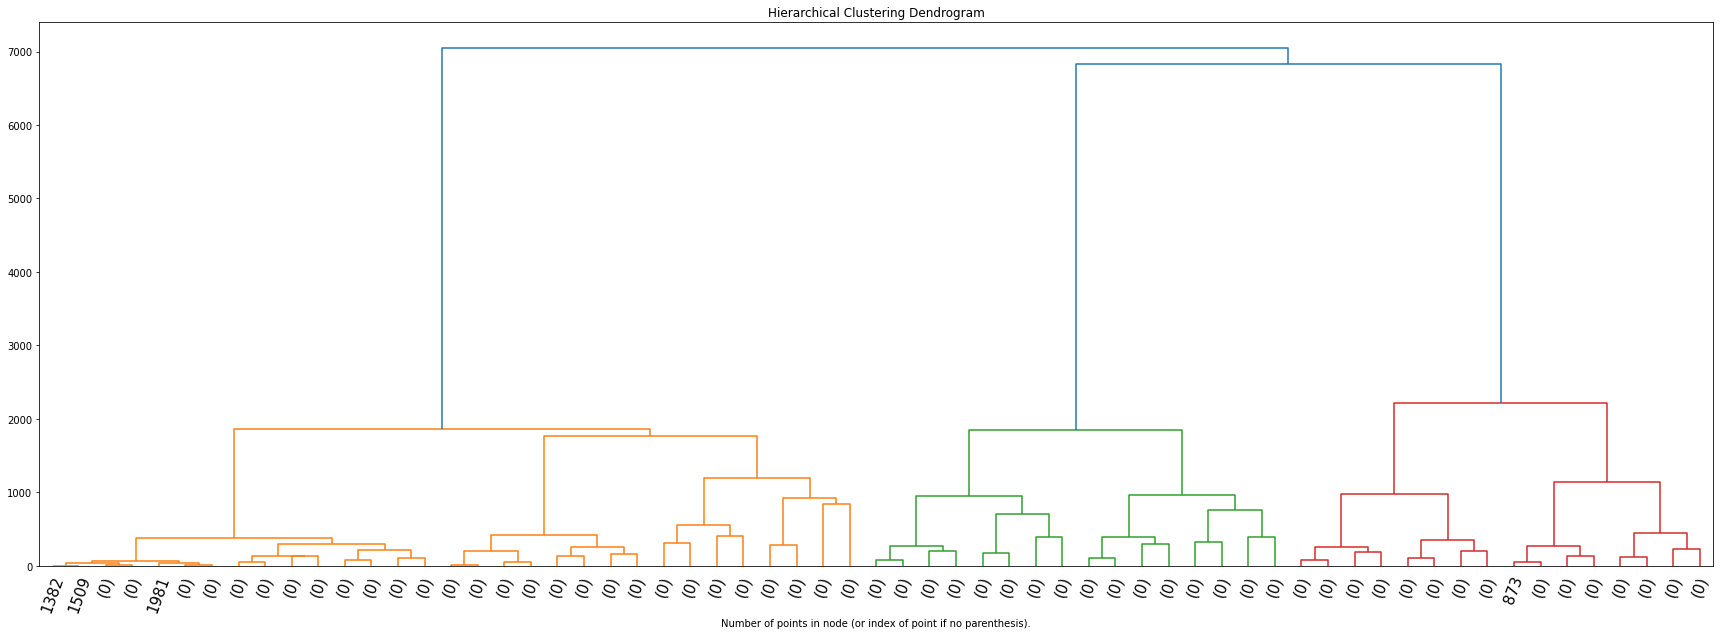

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=2, n_clusters=None)
model = model.fit(df)
plot_dendrogram(model, truncate_mode='level', p=5) # p=3,5,7

In [ ]:
df.head()

,Focal depth,Latitude,Longitude,Richter
0,33,-52.26,28.30,6.7
1,36,45.53,150.93,5.8
2,57,41.85,142.78,5.8
3,67,29.19,141.15,6.2
4,30,-21.66,169.81,6.0


In [ ]:
df.columns

Index(['Focal depth', 'Latitude', 'Longitude', 'Richter'], dtype='object')

# Scale data

i have quastions about this part:
1. if it possible to scale columns 'latitude' and 'longitude' and if not how can i use them in DBSCAN.?

2. if is possible to use whole data without scaling?

In [ ]:
def scale_data(data):

    X = data

    #STD scaler
    scaler = StandardScaler()

    # X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    X_scaled = scaler.fit_transform(X)

    # PCA
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)

    # pca_features = pca.fit_transform(X)
    # pca_df = pd.DataFrame(data=pca_features, columns=X.columns)

    return X, X_scaled, X_2d

In [ ]:
df.columns

Index(['Focal depth', 'Latitude', 'Longitude', 'Richter'], dtype='object')

In [ ]:
# df_to_scale = df[['Focal depth', 'Richter']]

In [ ]:
X, X_scaled, X_2d = scale_data(df)

DBSCAN (Density-based spatial clustering of applications with noise) - density based algorithm of clustering. <p>
Main assumption is that if points are close enough then they can be classified to the same cluster. If point has no close points it is considered as outlier. So DBSCAN can also be used as outlier detection model. <p>

![](https://i.stack.imgur.com/5aikc.png)

Lets define $N_i^{\epsilon} = \{x_j| x_j \in X, \rho (x_i, x_j) < \epsilon, i\neq j\}$ - set of reachable points for $x_i$ with $\epsilon$ distance. <p>

Better if we visualize how it works [demo](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

*   Points with $|N_i^{\epsilon}| > n$ are named core points. If two core points are reachable from each other, they are merged into one cluster.
*   If point is not core and is reachable to some core point, it is assigned to its' cluster. If there are several points the closest core point is choosed.
* If point has no core points in $N_i^{\epsilon}$ than it is assigned to outliers.

$\epsilon$ and $n$ are hyperparameters of this algorythm.

Drawbacks:


*   Have to choose $\epsilon$ and $n$.
*   DBSCAN is a metric based model so we need to normalize features and select correct metric.
*  Clusters with varying density are hard to detect.



In [ ]:
X_scaled.shape

(2178, 4)

In [ ]:
def dbscan(data):
  epsilon_param_options = np.arange(0.001, 10, 0.01)
  min_samples_param_options = np.arange(2, data.shape[1]+1, 1)
  param_grid = itertools.product(epsilon_param_options, min_samples_param_options)

  print('Amount of hyperparameters combinations: {}'.format(len(epsilon_param_options) * len(min_samples_param_options)))

  params_dict = {}

  for param_set in tqdm(param_grid, total=len(epsilon_param_options) * len(min_samples_param_options)):
    dbscan = DBSCAN(eps=param_set[0], min_samples=param_set[1])

    y_dbscan = dbscan.fit_predict(data)

    if len(set(y_dbscan) - set([-1])) == 3:
      params_dict['{}_{}_{}'.format(len(set(y_dbscan) - set([-1])), param_set[0], param_set[1])] = param_set
  return params_dict

In [ ]:
params_dict = dbscan(X_scaled)

Amount of hyperparameters combinations: 3000


  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
params_dict

{'3_0.8509999999999999_4': (0.8509999999999999, 4),
 '3_0.8609999999999999_4': (0.8609999999999999, 4),
 '3_0.8709999999999999_3': (0.8709999999999999, 3),
 '3_0.9009999999999999_3': (0.9009999999999999, 3),
 '3_0.9109999999999998_3': (0.9109999999999998, 3),
 '3_0.9209999999999998_3': (0.9209999999999998, 3),
 '3_0.9309999999999998_2': (0.9309999999999998, 2),
 '3_0.9409999999999998_2': (0.9409999999999998, 2),
 '3_0.9509999999999998_2': (0.9509999999999998, 2)}

In [ ]:
keys = list(params_dict.keys())
values = list(params_dict.values())

print(keys)
print(values)

['3_0.8509999999999999_4', '3_0.8609999999999999_4', '3_0.8709999999999999_3', '3_0.9009999999999999_3', '3_0.9109999999999998_3', '3_0.9209999999999998_3', '3_0.9309999999999998_2', '3_0.9409999999999998_2', '3_0.9509999999999998_2']
[(0.8509999999999999, 4), (0.8609999999999999, 4), (0.8709999999999999, 3), (0.9009999999999999, 3), (0.9109999999999998, 3), (0.9209999999999998, 3), (0.9309999999999998, 2), (0.9409999999999998, 2), (0.9509999999999998, 2)]


* How to determine **eps**?

We can calculate the distance from each point to its closest neighbour using the NearestNeighbors. The point itself is included in n_neighbors. The kneighbors method returns two arrays, one which contains the distance to the closest n_neighbors points and the other which contains the index for each of those points.

The optimal value for epsilon will be found at the point of maximum curvature.


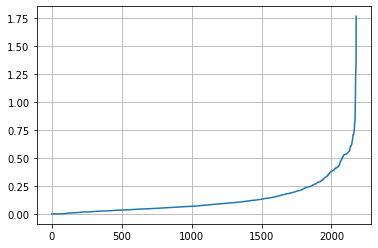

In [ ]:
neighbours = NearestNeighbors(n_neighbors=3)
nbrs = neighbours.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.grid(True)

* How to determine **min_samples**?


min_samples (default=5) is selected based on the domain knowledge.

If you do not have domain understanding, a rule of thumb is to derive min_samples from the number of dimensions D in the data set. min_samples >= D + 1. For 2D data, take min_samples = 4.

In [ ]:
epsilon = values[0][0]
min_sample = values[0][1]

In [ ]:
def dbscan_cls(data, eps, min_samples):
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)
  y_dbscan = dbscan.fit_predict(data)

  dbscan_labels_mapping = dict(zip([-1, 0, 1, 2], ['OUTLIER', 'label_0', 'label_1', 'label_2']))

  dbscan_label = pd.Series(y_dbscan).map(dbscan_labels_mapping)
  fig = px.scatter(df, x='Longitude', y='Latitude', color=dbscan_label)
  fig.update_layout(title='Quake in 2d space (DBSCAN labels)')
  fig.show()
  return dbscan_label, dbscan_labels_mapping, y_dbscan

In [ ]:
dbscan_label, dbscan_labels_mapping, y_dbscan = dbscan_cls(data=df, eps=epsilon, min_samples=min_sample)

In [ ]:
y_dbscan

array([-1, -1, -1, ..., -1, -1, -1])

In [ ]:
df.columns

Index(['Focal depth', 'Latitude', 'Longitude', 'Richter'], dtype='object')

In [ ]:
# df = df[['Focal depth', 'Latitude', 'Longitude', 'Richter']]

In [ ]:
df['kmeans_label'] = pd.Series(y_kmeans).map(kmeans_labels_mapping)
df['ground_truth'] = pd.Series(y_kmeans).map(kmeans_labels_mapping)
df['agglomerative_label'] = pd.Series(y_agglomerative).map(agglomerative_labels_mapping)
df['dbscan_label'] = pd.Series(y_dbscan).map(dbscan_labels_mapping)

In [ ]:
df.describe(include='all')

,Focal depth,Latitude,Longitude,Richter,kmeans_label,ground_truth,agglomerative_label,dbscan_label
count,2178.000000,2178.000000,2178.000000,2178.000000,2178,2178,2178,2157
unique,NaN,NaN,NaN,NaN,3,3,3,4
top,NaN,NaN,NaN,NaN,label0,label0,label1,OUTLIER
freq,NaN,NaN,NaN,NaN,1437,1437,1430,2073
mean,74.359963,7.961997,54.914835,5.977181,NaN,NaN,NaN,NaN
std,116.467797,30.545583,118.875581,0.189426,NaN,NaN,NaN,NaN
min,0.000000,-66.490000,-179.960000,5.800000,NaN,NaN,NaN,NaN
25%,21.000000,-12.432500,-67.782500,5.800000,NaN,NaN,NaN,NaN
50%,39.000000,0.210000,122.100000,5.900000,NaN,NaN,NaN,NaN
75%,68.000000,36.480000,146.860000,6.100000,NaN,NaN,NaN,NaN


In [ ]:
df.columns

Index(['Focal depth', 'Latitude', 'Longitude', 'Richter', 'kmeans_label',
       'ground_truth', 'agglomerative_label', 'dbscan_label'],
      dtype='object')

In [ ]:
df['dbscan_label'].fillna('OUTLIER', inplace=True)

In [ ]:
# df.dropna(axis=1, inplace=True)
df.isna().sum()

Focal depth            0
Latitude               0
Longitude              0
Richter                0
kmeans_label           0
ground_truth           0
agglomerative_label    0
dbscan_label           0
dtype: int64

# Clustering quality metrics

Metrics for measuring quality of clustering can be divided into 2 main groups - when we have ground truth labels and when we don't. <p>

For measuring quality with labels we can use mutual information score (MI), adjusted Rand score.

For fully unsupervised measuring usually used silhoette score and rarely Calinsky-Harabaz score. <p>


* Rand index:
 * $a$, the number of pairs of elements in S that are in the same subset in X and in the same subset in Y
 * $b$, the number of pairs of elements in   S that are in different subsets in   X and in different subsets in  Y
 * $c$, the number of pairs of elements in   S that are in the same subset in   X and in different subsets in   Y
 * $d$, the number of pairs of elements in   S that are in different subsets in  X and in the same subset in Y <p>
 * $R = \frac{a+b}{a+b+c+d} = \frac{a+b}{C^n_2}$

Lest denote $H(.)$ - entropy score, $H(.|.)$ - conditional entropy, $Y$ - ground truth labels, $C$ - cluster labels. <p>
* Mutual information score: <p>
 * $MI(Y,C) = H(Y) - H(Y|C)$ <p>
* Normalized mutual information score: <p>
 * $NMI(Y,C) = \frac{2MI(Y,C)}{H(Y) + H(C)}$

For evaluation we will use adjusted version of MI and Rand index. Adjustment is taking into consideration random clustering as basline.

In [ ]:
label_cols = ['kmeans_label', 'agglomerative_label', 'dbscan_label']

In [ ]:
for col in label_cols:
    print(f'Adjusted MI score for {col} = {adjusted_mutual_info_score(df["ground_truth"], df[col])}')

Adjusted MI score for kmeans_label = 1.0
Adjusted MI score for agglomerative_label = 0.8992952664065428
Adjusted MI score for dbscan_label = 0.030523492472933157


In [ ]:
for col in label_cols:
    print(f'Adjusted rand score for {col} = {adjusted_rand_score(df["ground_truth"], df[col])}')

Adjusted rand score for kmeans_label = 1.0
Adjusted rand score for agglomerative_label = 0.9472873021800254
Adjusted rand score for dbscan_label = -0.040136958349674436


In [ ]:
for col in label_cols:
    print(f'Calinski Harabasz score for {col} = {calinski_harabasz_score(X_scaled, df[col])}')

Calinski Harabasz score for kmeans_label = 779.391583773992
Calinski Harabasz score for agglomerative_label = 778.8247365295595
Calinski Harabasz score for dbscan_label = 23.473843573885258


# Task

Evaluation criteria (100% in total):

● Exploratory analysis (there are some specific characteristics of features, which may change the
result of the analysis) (10%)

● Build K-Means with 15 clusters (10%)

● Determine optimal number of clusters for K-Means (10%)

● Create visualization for the obtained clusters (10%)

● Try other clustering algorithms; tune their hyperparameters to achieve better results. You should
use at least two different algorithms (20%)

● Use labelled and unlabeled metrics to estimate quality of clusters you built. As ground truth use
cluster labels from K-Means, choose most similar algorithm (20%)

● Explain the final choice of best clusterizations: give interpretation of clusters (10%)

● Visualize the best clusterizations in your opinion on the world map. (10%)